In [1]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm

import numpy as np
import pandas as pd


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)
plt.rcParams['font.family'] = 'serif'


In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
!pip3 uninstall torch-scatter

In [ ]:
!pip3 install torch-cluster torch-scatter torch-sparse torch-spline-conv -f https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html

In [ ]:
!pip3 install torch-geometric

In [ ]:
!pip3 install jupyterlab ase e3nn pandas seaborn scipy scikit-learn mendeleev

In [ ]:
!git clone https://github.com/nguyen-group/GNNOpt.git

# Predicting absorption coefficient with GNNOpt from a crystal structure with CIF file

## Getting started

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.io import read, write
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
#from ase_notebook import AseView, ViewConfig, get_example_atoms
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# utilities
import time
from mendeleev import element
from tqdm import tqdm

# Add the external folder path to sys.path
import sys
sys.path.append("./GNNOpt/utils")
from utils_data import (load_data, plot_example, plot_predictions)
from utils_model import Network, visualize_layers

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])

# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

/home/masvel/courses/stats/.venv/lib/python3.10/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/masvel/courses/stats/.venv/lib/python3.10/site-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(
/home/masvel/courses/stats/.venv/lib/python3.10/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/masvel/courses/stats/.venv/lib/python3.10/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


torch device: cpu


In [3]:
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view

P = np.eye(3) * 2
P
mos2 = read('MoS2.cif')
bigger_mos2 = make_supercell(mos2, P)
write('MoS2_big.cif', bigger_mos2)
view(bigger_mos2, viewer='x3d')

## Open and visualize the CIF file

<Axes: title={'center': 'Mo16S32'}>

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

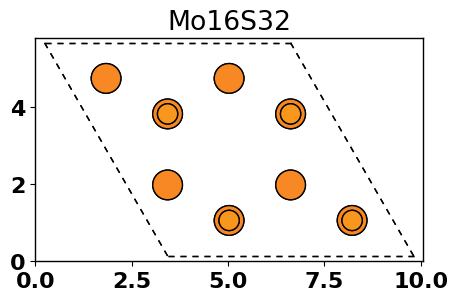

In [4]:
cif_file_path = 'MoS2_big.cif'

# Reading the CIF file
struct = read(cif_file_path)

# Extracting atomic positions
positions = struct.get_positions()

# Extracting the chemical formula
formula = struct.get_chemical_formula()

# Extracting atomic symbols
symbols = struct.get_chemical_symbols()
z = dict(zip(symbols, range(len(symbols))))

# Extracting cell dimensions
cell = struct.get_cell()

# Create the plot
fig, ax = plt.subplots(figsize=(5,5))
norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in list(symbols)]))]
ax.set_title(formula)
plot_atoms(struct, ax, radii=0.25, colors=color, rotation=('0x,0y,0z'))

## Reconstruction data

In [5]:
energy_min = 0.0 #Unit of energy in eV
energy_max = 50.0 #Unit of energy in eV
nstep = 251 #Number of the energy points

new_x = np.linspace(energy_min, energy_max, nstep)
atoms = Atoms(symbols=symbols, positions=positions, cell=cell, pbc=True)

# Create a pandas DataFrame
df = pd.DataFrame({})
Data = dict()

# Add the atomic positions to the DataFrame
Data['id'] = [0]
Data['formula'] = [formula]
Data['structure'] = [atoms]
Data['energies'] = [new_x]
Data['absorption_coefficient'] = [np.zeros_like(new_x)]
df = pd.DataFrame(Data)

# Display the DataFrame
df

,id,formula,structure,energies,absorption_coefficient
0,0,Mo16S32,"(Atom('Mo', [-1.596118916080422e-08, 1.8430394...","[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Feature representation

In [6]:
# one-hot encoding atom type
type_encoding = {}
specie_mass = []
specie_dipole = []
specie_radius = []
for Z in tqdm(range(1, 119), bar_format=bar_format):              #Change 109 to 119 to increase the number of elements
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1
    Z_mass = specie.mass                                           # Atomic Mass (amu)
    Z_dipole = element(specie.symbol).dipole_polarizability        # Dipole Polarizability (a0^3)
    if Z_dipole == None:
        Z_dipole = 67.0
    Z_radius = element(specie.symbol).covalent_radius_pyykko       # Covalent radius by Bragg (pm)
    specie_mass.append(Z_mass)
    specie_dipole.append(Z_dipole)
    specie_radius.append(Z_radius)

type_onehot = torch.eye(len(type_encoding))
mass_onehot = torch.diag(torch.tensor(specie_mass))
dipole_onehot = torch.diag(torch.tensor(specie_dipole))
radius_onehot = torch.diag(torch.tensor(specie_radius))
#print(mass_onehot)

100%|██████████| 118/118 [01:48<00:00,  1.08it/s]


## Build dataloader

In [7]:
# Scale value for the absorption coefficient from mean value of ground truth data
scale_data = 2234715.2380567943

# build data
def build_data(entry, type_encoding, type_onehot, r_max=5.):
    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)

    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)

    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x_mass=mass_onehot[[type_encoding[specie] for specie in symbols]],       # atomic mass (node feature)
        x_dipole=dipole_onehot[[type_encoding[specie] for specie in symbols]],   # atomic dipole polarizability (node feature)
        x_radius=radius_onehot[[type_encoding[specie] for specie in symbols]],   # atomic covalent radius (node feature)
        z=type_onehot[[type_encoding[specie] for specie in symbols]],            # atom type (node attribute)
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        y=torch.from_numpy(entry.absorption_coefficient/scale_data).unsqueeze(0)
    )

    return data

r_max = 6. # cutoff radius
df['data'] = df.progress_apply(lambda x: build_data(x, type_encoding, type_onehot, r_max), axis=1)

100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


In [8]:
# load indices
run_time = '240406'

# format dataloaders
batch_size = 1
dataloader_test = tg.loader.DataLoader(df['data'].values, batch_size=batch_size)

## Network architecture

We build a model based on the **Network** described in the e3nn Documentation, modified to incorporate the periodic boundaries we imposed on the crystal graphs. The network applies equivariant convolutions to each atomic node and finally takes an average over all nodes, normalizing the output.

In [9]:
class MixingLinear(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(MixingLinear, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(self.out_feature, self.in_feature))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=5**0.5)

    def forward(self, x):
        weight = torch.abs(self.weight)/(torch.sum(torch.abs(self.weight), dim=1, keepdim=True)+1e-10)
        return F.linear(x, weight)

In [10]:
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, **kwargs):
        # override the `reduce_output` keyword to instead perform an averge over atom contributions
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True

        super().__init__(**kwargs)

        # embed the one-hot encoding
        self.em_type = nn.Linear(in_dim, em_dim)    #Linear layer for atom type
        self.em_mass = nn.Linear(in_dim, em_dim)    #Linear layer for atom mass
        self.em_dipole = nn.Linear(in_dim, em_dim)  #Linear layer for atom dipole polarizability
        self.em_radius = nn.Linear(in_dim, em_dim)  #Linear layer for atom covalent radius
        self.em_mixing = MixingLinear(3, 1)            #Linear layer for mixing the atom features (mass, dipole, radius)

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.z = F.relu(self.em_type(data.z))
        data.x_mass = F.relu(self.em_mass(data.x_mass))
        data.x_dipole = F.relu(self.em_dipole(data.x_dipole))
        data.x_radius = F.relu(self.em_radius(data.x_radius))
        tmp = torch.stack([data.x_mass, data.x_dipole, data.x_radius], dim=0)      # stack the atom features in shape (3, N, em_dim)
        tmp2 = torch.permute(tmp, (1, 2, 0))                                       # permute the tensor to (N, em_dim, 3)
        data.x = torch.permute(self.em_mixing(tmp2),(2, 0, 1)).reshape(-1, em_dim) # reshape the tensor to (N, em_dim)
        output = super().forward(data)
        # ReLu for last convolution will force output positive value, if output have negative value, it step should be neglected
        output = torch.relu(output)

        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example

        # normalization output from 0 to 1
        #maxima, _ = torch.max(output, dim=1)
        #output = output.div(maxima.unsqueeze(1))

        return output

In [11]:
out_dim = len(df.iloc[0]['energies'])      # about 250 points
em_dim = 64
n_train_mean = 51.03625673689368           # take same training value of neighbors with previous model

model = PeriodicNetwork(
    in_dim=118,                            # dimension of one-hot encoding of atom type
    em_dim=em_dim,                         # dimension of atom-type embedding
    irreps_in=str(em_dim)+"x0e",           # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=str(out_dim)+"x0e",         # out_dim scalars (L=0 and even parity) to output
    irreps_node_attr=str(em_dim)+"x0e",    # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    layers=2,                              # number of nonlinearities (number of convolutions = layers + 1)
    mul=32,                                # multiplicity of irreducible representations
    lmax=2,                                # maximum order of spherical harmonics
    max_radius=r_max,                      # cutoff radius for convolution
    num_neighbors=n_train_mean,            # scaling factor based on the typical number of neighbors
    reduce_output=True                     # whether or not to aggregate features of all atoms at the end
)

print(model)

PeriodicNetwork(
  (layers): ModuleList(
    (0): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(64x0e x 64x0e -> 96x0e+32x1o+32x2e | 393216 paths | 393216 weights)
        (lin1): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e | 262144 paths | 262144 weights)
        (fc): FullyConnectedNet[10, 100, 192]
        (tp): TensorProduct(64x0e x 1x0e+1x1o+1x2e -> 64x0e+64x1o+64x2e | 192 paths | 192 weights)
        (lin2): FullyConnectedTensorProduct(64x0e+64x1o+64x2e x 64x0e -> 96x0e+32x1o+32x2e | 655360 paths | 655360 weights)
      )
      (second): Gate (96x0e+32x1o+32x2e -> 32x0e+32x1o+32x2e)
    )
    (1): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(32x0e+32x1o+32x2e x 64x0e -> 160x0e+32x1o+32x1e+32x2o+32x2e | 458752 paths | 458752 weights)
        (lin1): FullyConnectedTensorProduct(32x0e+32x1o+32x2e x 64x0e -> 32x0e+32x1o+32x2e | 196608 paths | 196608 weights)
        (fc): FullyConnectedNet[10, 100, 

# Training
The model is trained using a mean-squared error loss function with an Adam optimizer.

In [12]:
opt = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)

#loss_fn = torch.nn.HuberLoss()
loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

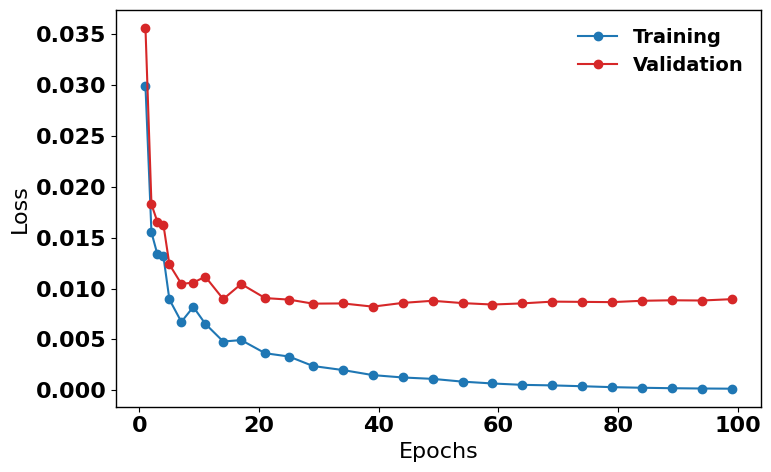

In [13]:
# load pre-trained model and plot its training history
run_name = 'model_alpha_' + run_time
history = torch.load('./GNNOpt/model/' + run_name + '.torch', map_location=device)['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(steps, loss_train, 'o-', label="Training", color='C0')
ax.plot(steps, loss_valid, 'o-', label="Validation", color='C3')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

## Results
We evaluate our model by visualizing the predicted and true DoS in each error quartile. We further compare the hidden features learned for each node to the partial DoS.

In [14]:
# predict on all data
# run_name = 'model_240327'
model.load_state_dict(torch.load('./GNNOpt/model/'+run_name + '.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)
df['mse'] = 0.
df['y_pred'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.y, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(d.y) - 1, 'y_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.y) - 1, 'mse'] = loss
        i0 += len(d.y)

df['y_pred'] = df['y_pred'].map(lambda x: x[0])*scale_data

100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


In [15]:
from scipy.constants import e, hbar, c
def ev_to_wave(ev): 
    return 2 * np.pi * hbar * c / ev / e 
def ev_to_omega(ev):
    return ev / hbar * e 

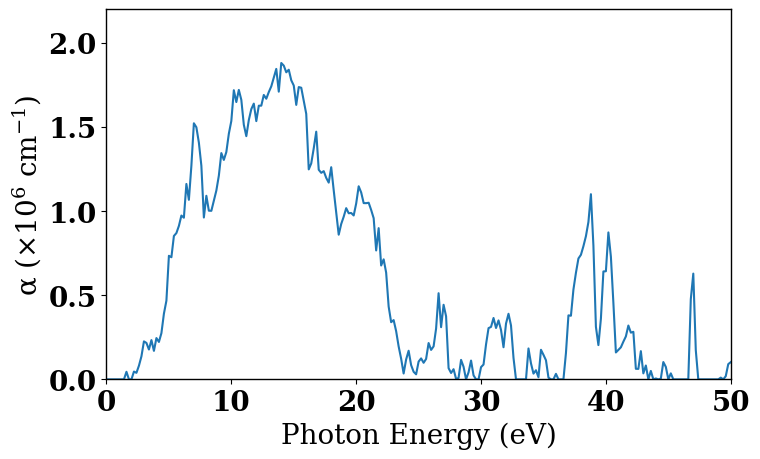

In [16]:
energy = df.iloc[0]['energies']
alpha = df.iloc[0]['y_pred']

fontsize = 20
textsize = 20
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = textsize

# Create figure object
fig, ax = plt.subplots(figsize=(8,5))

# Plot the abosorption coefficient
ax.plot((energy), alpha/10**6, '-C0', label='GNNOpt')
# Add the x and y-axis labels
# ax.set_xlabel('Photon WaveLength (nm)')
ax.set_xlabel('Photon Energy (eV)')
ax.set_ylabel(r'$\alpha$ ($\times 10^6$ cm$^{-1}$)')
# Set the axis limits
ax.set_xlim(0, 50)
ax.set_ylim(0, 2.2)

plt.tight_layout()
# Save a figure to the pdf file
plt.savefig(formula+'_optic.pdf')
plt.show()

In [58]:
df = pd.read_csv('Ermolaev-o.csv').astype(float)
wave = df['wl'] * 1000
n_erm = df['n']


/tmp/ipykernel_163186/3704430071.py:12: RuntimeWarning: invalid value encountered in divide
  integrand = omega * epsilon_2 / (omega**2 - omega[i]**2)
/tmp/ipykernel_163186/3704430071.py:12: RuntimeWarning: divide by zero encountered in divide
  integrand = omega * epsilon_2 / (omega**2 - omega[i]**2)


Text(0, 0.5, '$\\varepsilon_2$')

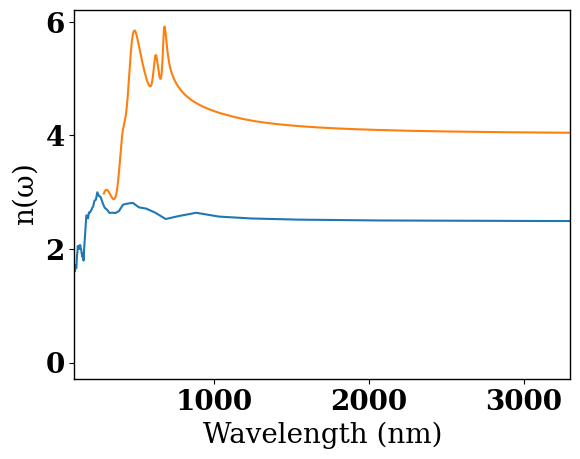

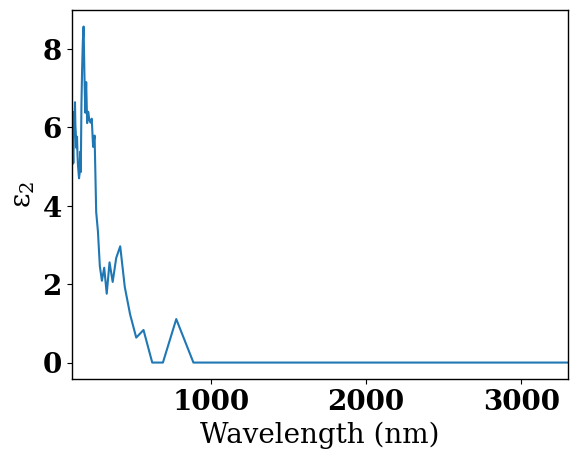

In [67]:
from scipy.integrate import simpson

omega = ev_to_omega(energy[1:])


epsilon_2 = (2 * alpha[1:] * c) / omega * 100


def calculate_epsilon_1(omega, epsilon_2):
    epsilon_1 = np.zeros_like(omega)
    for i in range(len(omega)):
        integrand = omega * epsilon_2 / (omega**2 - omega[i]**2)  
        integrand[i] = 0  # исключение сингулярности
        epsilon_1[i] = (2 / np.pi) * simpson(y=integrand, x=omega)
        
    return epsilon_1


epsilon_1 = calculate_epsilon_1(omega, epsilon_2)



n = np.sqrt((epsilon_1 + np.sqrt(epsilon_1**2 + epsilon_2**2)) / 2) 
plt.plot(2 * np.pi * c / omega * 10 ** 9 , n)
plt.plot(wave, n_erm)
plt.xlabel('Wavelength (nm)')
plt.ylabel('$n (\omega)$')
plt.xlim([100, 3300])
plt.figure()
plt.xlim([100, 3300])
plt.plot(2 * np.pi * c / omega * 10 ** 9 , epsilon_2)
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\\varepsilon_2$')

/tmp/ipykernel_163186/517992860.py:12: RuntimeWarning: invalid value encountered in divide
  integrand = omega * epsilon_2 / (omega**2 - omega[i]**2)
/tmp/ipykernel_163186/517992860.py:12: RuntimeWarning: divide by zero encountered in divide
  integrand = omega * epsilon_2 / (omega**2 - omega[i]**2)


Text(0, 0.5, '$\\varepsilon_1$')

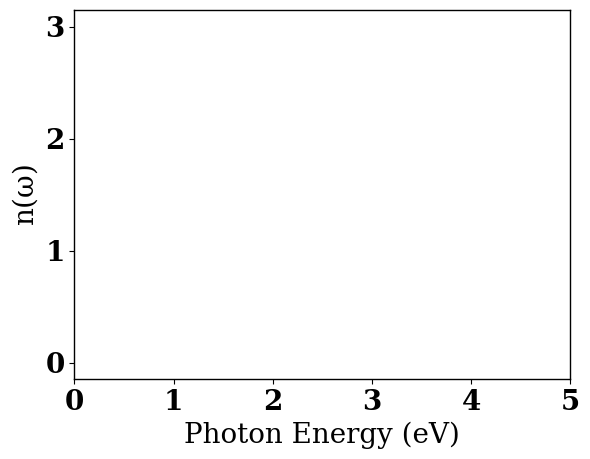

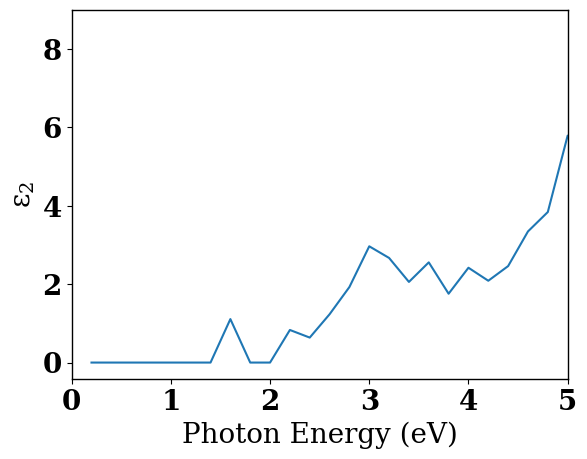

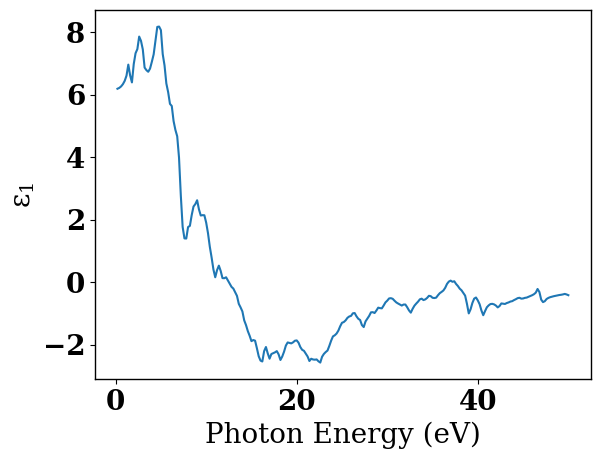

In [18]:
omega = ev_to_omega(energy)[1:]
epsilon_2 = (2 * alpha[1:] * c) / omega * 100
epsilon_1 = calculate_epsilon_1(omega, epsilon_2)
n = np.sqrt((epsilon_1  + np.sqrt(epsilon_1**2 + epsilon_2**2)) / 2)


plt.plot(2 * np.pi * c /  omega * 10 ** 9, n)
plt.xlabel('Photon Energy (eV)')
plt.ylabel('$n (\omega)$')

# plt.xticks([i for i in range(0, 50, 5)])
plt.xlim([0, 5])
plt.figure()
plt.xlim([0, 5])
plt.plot(omega * hbar / e, epsilon_2)
plt.xlabel('Photon Energy (eV)')
plt.ylabel('$\\varepsilon_2$')

plt.figure()
plt.plot(omega * hbar / e, epsilon_1)
plt.xlabel('Photon Energy (eV)')
plt.ylabel('$\\varepsilon_1$')